In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

from ionpy.analysis import ResultsLoader
from ese.experiment.experiment import CalibrationExperiment
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

In [2]:
path = f"{root}/WMH_aug_runs"

dfc = rs.load_configs(
    path,
    properties=False,
)

df = rs.load_metrics(dfc)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [3]:

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

best_exp = rs.get_best_experiment(
    df=df,
    exp_class=CalibrationExperiment,
    device="cuda"
)
best_exp.build_dataloader()

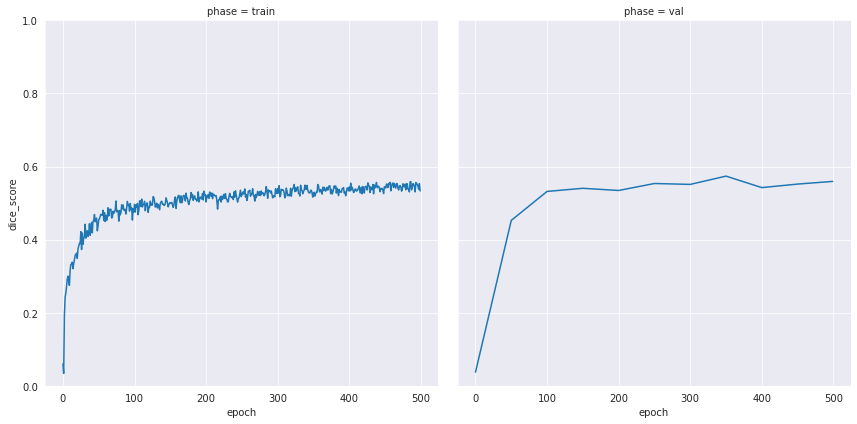

In [4]:
best_exp.vis_loss_curves(height=6)

In [5]:
from ese.experiment.analysis.inference import get_dataset_perf 

# val_perf is a dict where each item is the subj id
predictions_list = get_dataset_perf(
    exp=best_exp, 
    split="val"
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
from ese.experiment.analysis.inference import get_pixelinfo_df

pixel_preds_df = get_pixelinfo_df(
    data_points=predictions_list,
    num_bins=10,
    num_labels=2
    )

  0%|          | 0/15 [00:00<?, ?it/s]

In [7]:
import pandas as pd

# Calculate average conf and accuracy for each bin
avg_values = pixel_preds_df.groupby('bin').agg({'conf': 'mean', 'accuracy': 'mean'}).reset_index()

# Prepare a list to store the new rows
new_rows = []

# Create new rows for the averages with a special label 'avg'
for _, row in avg_values.iterrows():
    new_rows.append({'bin': row['bin'], 'conf': row['conf'], 'accuracy': row['accuracy'], 'label': 'avg'})

# Concatenate the original DataFrame with the new rows
pixel_preds_df = pd.concat([pixel_preds_df, pd.DataFrame(new_rows)], ignore_index=True)

# Melt the DataFrame
pixel_preds_df_melted = pixel_preds_df.melt(id_vars=['bin', 'bin_num', 'label'], value_vars=['conf', 'accuracy'], var_name='metric', value_name='value')
pixel_preds_df_melted = pixel_preds_df_melted.sort_values('bin_num')

In [10]:
# Define a custom palette
unique_labels = pixel_preds_df_melted['label'].unique()
palette_colors = sns.color_palette('viridis', n_colors=len(unique_labels) - 1)  # -1 because we'll assign a distinct color to 'avg'
palette_dict = {label: color for label, color in zip(unique_labels, palette_colors)}
palette_dict['avg'] = 'gray'  # Assigning red color for 'avg' label

Text(0.5, 0.98, 'WMH Confidence vs. Accuracy per Bin')

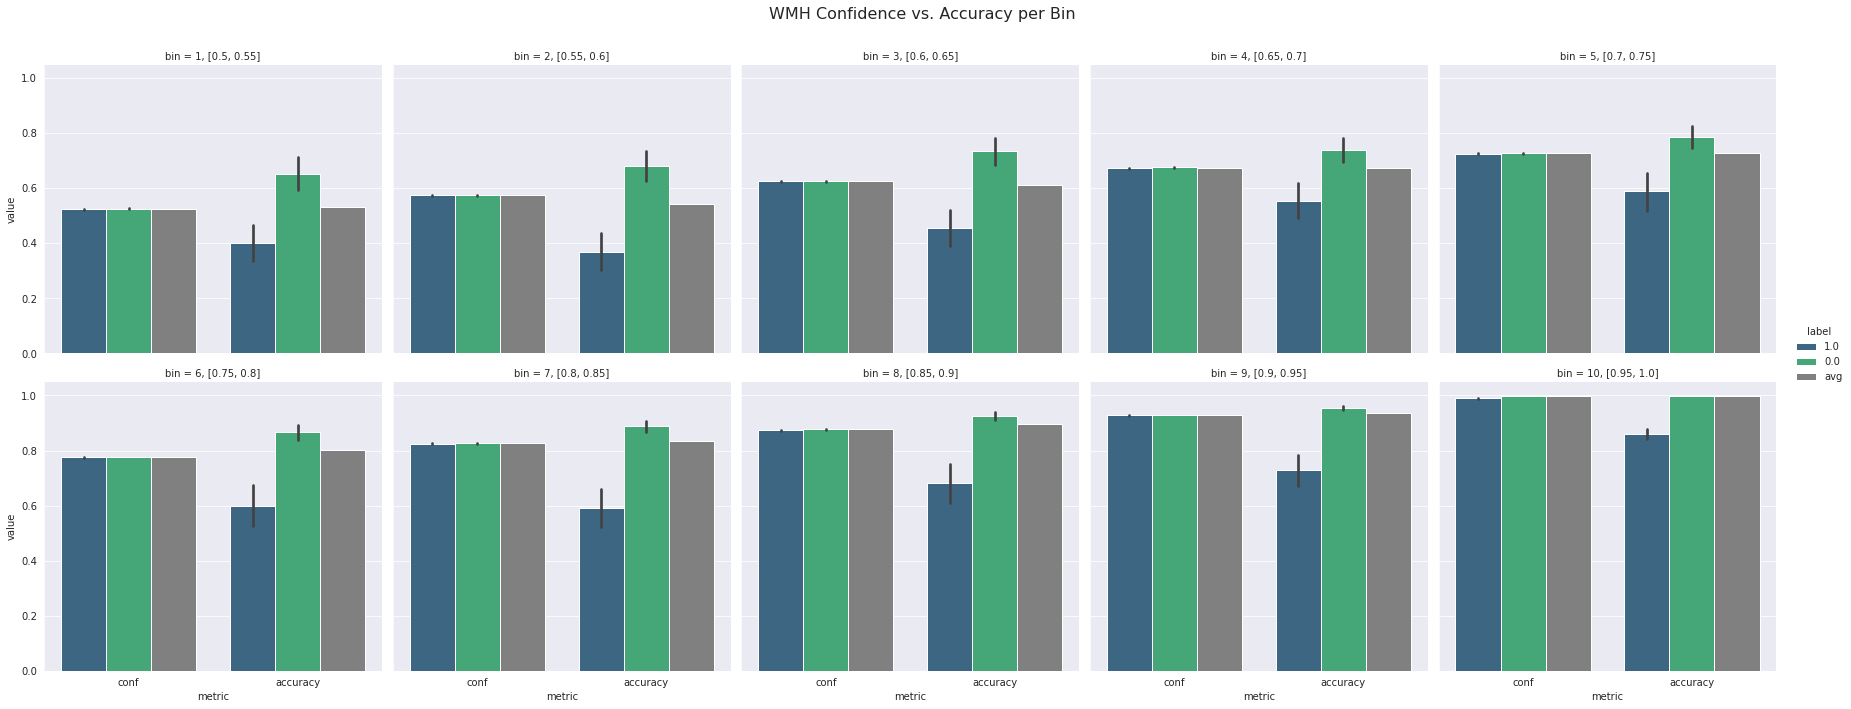

In [15]:
# Using relplot to create a FacetGrid of scatter plots
g = sns.catplot(data=pixel_preds_df_melted, 
                x='metric', 
                y='value', 
                hue='label',
                col='bin', 
                col_wrap=5, 
                kind='bar', 
                height=5,
                palette=palette_dict)
# Adjusting the titles
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('WMH Confidence vs. Accuracy per Bin', fontsize=16)